In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

## 5.1 Bayesian Computation

### Simulated Case 

In [5]:
# simulated one N(theta, 1)
x = 2
N = 100000
num = 0
denom = 0

for i in range(N):
    theta = x + np.random.randn()
    num = num + theta/(1+theta**2)
    denom = denom + 1/(1+theta**2)
delta21 = num/denom
delta21

1.2903616678140268

In [20]:
# simulated two
x = 2
N = 100000
num = 0
denom = 0

for i in range(N):
    a = np.random.randn(1, 2) + 2
    theta = a[0][0]/a[0][1]
    num = num + theta * np.exp(-0.5 * (x-theta)**2)
    denom = denom + np.exp(-0.5 * (x-theta)**2)
delta21 = num/denom
delta21

1.3380404812458386

In [21]:
# Not simulated
from scipy import integrate

In [26]:
x = 2
num = lambda th: th * np.exp(-0.5*(x-th)**2)/(1+th**2)
denom = lambda th: np.exp(-0.5*(x-th)**2)/(1+th**2)
delta2 = integrate.quad(num, -np.infty, np.infty)[0]/integrate.quad(denom, -np.infty, np.infty)[0]
delta2

1.2821951026935339

In [27]:
# Errors

numerator =integrate.quad(num,-np.infty, np.infty)[0]    #0.9159546679977636
denominator=integrate.quad(denom,-np.infty, np.infty)[0] #0.714364503556127
errnum=integrate.quad(num,-np.infty, np.infty)[1]        #1.0415234856193602e-09
errdenom=integrate.quad(denom,-np.infty, np.infty)[1]    #1.2022419107752649e-08

err = delta2 * (errnum/numerator + errdenom/denominator)
print(err)   #2.3036713479165735e-08

2.3036713551596704e-08


### Laplace Approximation

In [58]:
from scipy.stats import gamma
from scipy.stats import norm

In [59]:
# x|theta ~ Ga(r, theta), theta ~ Ga(alpha, beta)
r = 20
alpha = 5
beta = 1
x = 2

xx = np.arange(0, 16, 0.01)

y1 = gamma.pdf(xx, a=r+alpha, scale=1/(beta+x))
y2 = norm.pdf(xx, (r-1+alpha)/(beta+x), np.sqrt(r-1+alpha)/(beta+x))

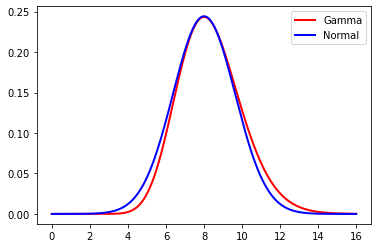

In [60]:
plt.plot(xx, y1, c="r", linewidth=2)
plt.plot(xx, y2, c="b", linewidth=2)
plt.legend(["Gamma", "Normal"])
plt.show()

In [61]:
# 95% Credible Set
norm.ppf(0.025, (r-1+alpha)/(beta+x), np.sqrt(r-1+alpha)/(beta+x)), norm.ppf(0.975, (r-1+alpha)/(beta+x), np.sqrt(r-1+alpha)/(beta+x))

(4.799392215763127, 11.200607784236873)

In [62]:
upper = gamma.cdf(11.200607784236873, a=r+alpha, scale=1/(beta+x))
lower = gamma.cdf(4.799392215763127, a=r+alpha, scale=1/(beta+x))

In [63]:
# approximate posterior range
upper - lower

0.9404006787256667

In [77]:
# Exact 
from scipy.special import gamma
gamma(r+alpha)/ (beta+x)**(r+alpha)

732275159630.8094

In [79]:
np.sqrt(2 * np.pi) * (r+alpha-1)**(r + alpha -1/2) /((beta + x)**(r +alpha)) * np.exp(-(r+alpha -1))

729737093278.3551